In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity, FactorAnalyzer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
data = pd.read_csv("C:\\Users\\Dell\\Downloads\\Students Social Media Addiction.csv")

In [ ]:
data.head()

In [ ]:
data = data.drop('Student_ID', axis=1)

In [ ]:
categorical_cols = ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 
                    'Affects_Academic_Performance', 'Relationship_Status']
for col in categorical_cols:
    print(f"\nFrequency Counts for {col}:")
    print(data[col].value_counts())

In [ ]:
# Group countries into regions to reduce dimensionality
region_mapping = {
    'Bangladesh': 'South Asia', 'India': 'South Asia', 'Pakistan': 'South Asia', 'Nepal': 'South Asia', 
    'Sri Lanka': 'South Asia', 'Maldives': 'South Asia', 'Bhutan': 'South Asia', 'Afghanistan': 'South Asia',
    'USA': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'Brazil': 'South America', 'Argentina': 'South America', 'Chile': 'South America', 'Colombia': 'South America',
    'Peru': 'South America', 'Venezuela': 'South America', 'Ecuador': 'South America', 'Uruguay': 'South America',
    'Paraguay': 'South America', 'Bolivia': 'South America',
    'UK': 'Europe', 'Germany': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe', 
    'Poland': 'Europe', 'Russia': 'Europe', 'Finland': 'Europe', 'Denmark': 'Europe', 'Ireland': 'Europe',
    'Switzerland': 'Europe', 'Netherlands': 'Europe', 'Sweden': 'Europe', 'Norway': 'Europe', 'Austria': 'Europe',
    'Portugal': 'Europe', 'Greece': 'Europe', 'Belgium': 'Europe', 'Czech Republic': 'Europe', 'Slovakia': 'Europe',
    'Croatia': 'Europe', 'Serbia': 'Europe', 'Slovenia': 'Europe', 'Estonia': 'Europe', 'Latvia': 'Europe',
    'Lithuania': 'Europe', 'Ukraine': 'Europe', 'Moldova': 'Europe', 'Belarus': 'Europe', 'Romania': 'Europe',
    'Hungary': 'Europe', 'Cyprus': 'Europe', 'Malta': 'Europe', 'Luxembourg': 'Europe', 'Monaco': 'Europe',
    'Andorra': 'Europe', 'San Marino': 'Europe', 'Vatican City': 'Europe', 'Montenegro': 'Europe', 
    'Albania': 'Europe', 'North Macedonia': 'Europe', 'Kosovo': 'Europe', 'Bosnia': 'Europe',
    'Japan': 'East Asia', 'South Korea': 'East Asia', 'China': 'East Asia', 'Taiwan': 'East Asia', 
    'Hong Kong': 'East Asia',
    'Australia': 'Oceania', 'New Zealand': 'Oceania',
    'Singapore': 'Southeast Asia', 'Malaysia': 'Southeast Asia', 'Thailand': 'Southeast Asia', 
    'Vietnam': 'Southeast Asia', 'Philippines': 'Southeast Asia', 'Indonesia': 'Southeast Asia',
    'UAE': 'Middle East', 'Qatar': 'Middle East', 'Kuwait': 'Middle East', 'Bahrain': 'Middle East', 
    'Oman': 'Middle East', 'Jordan': 'Middle East', 'Lebanon': 'Middle East', 'Iraq': 'Middle East', 
    'Yemen': 'Middle East', 'Syria': 'Middle East', 'Turkey': 'Middle East', 'Israel': 'Middle East',
    'South Africa': 'Africa', 'Nigeria': 'Africa', 'Kenya': 'Africa', 'Ghana': 'Africa', 'Egypt': 'Africa', 
    'Morocco': 'Africa',
    'Iceland': 'Europe', 'Bahamas': 'North America', 'Jamaica': 'North America', 'Trinidad': 'North America',
    'Costa Rica': 'North America', 'Panama': 'North America',
    'Kazakhstan': 'Central Asia', 'Uzbekistan': 'Central Asia', 'Kyrgyzstan': 'Central Asia', 
    'Tajikistan': 'Central Asia', 'Armenia': 'Central Asia', 'Azerbaijan': 'Central Asia', 'Georgia': 'Central Asia'
}
data['Region'] = data['Country'].map(region_mapping)

In [ ]:
# Encode categorical variables
le = LabelEncoder()
data_encoded = data.copy()
data_encoded['Gender'] = le.fit_transform(data['Gender'])  # 0: Female, 1: Male
data_encoded['Affects_Academic_Performance'] = le.fit_transform(data['Affects_Academic_Performance'])  # 0: No, 1: Yes

In [ ]:
# One-hot encode with binary (0/1) output
data_encoded = pd.get_dummies(data_encoded, columns=['Academic_Level', 'Region', 'Most_Used_Platform', 'Relationship_Status'], 
                              drop_first=True, dtype=int)

In [ ]:
data_encoded.drop('Country',axis=1,inplace = True)

In [ ]:
# Select continuous variables for PCA
continuous_cols = ['Age','Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 
                   'Conflicts_Over_Social_Media', 'Addicted_Score']


# Handle missing values (if any) by imputing with mean
data[continuous_cols] = data[continuous_cols].fillna(data[continuous_cols].mean())

# Standardize continuous variables
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[continuous_cols])
data_scaled_df = pd.DataFrame(data_scaled, columns=continuous_cols)




In [ ]:
# Combine standardized continuous variables with encoded categorical variables
# Select only the binary encoded columns from data_encoded
encoded_cols = [col for col in data_encoded.columns if col not in continuous_cols + ['Age', 'Country']]
data_combined = pd.concat([data_scaled_df.reset_index(drop=True), data_encoded[encoded_cols].reset_index(drop=True)], axis=1)


In [ ]:
# 1. Principal Component Analysis (PCA)
pca = PCA(n_components=len(data_combined.columns))  # Use all possible components
pca_result = pca.fit_transform(data_combined)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

significant_pcs = np.where(explained_variance > 0.04 )[0]
significant_pc_labels = [f'PC{i+1}' for i in significant_pcs]

# Printed outputs
print("\nPCA Explained Variance Ratio (First 15 PCs):")
print(explained_variance[:15])
print("\nCumulative Explained Variance (First 15 PCs):")
print(cumulative_variance[:15])

# Variable contributions (loadings) for significant PCs
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(data_combined.columns))], 
                        index=data_combined.columns)
loadings_significant = loadings[significant_pc_labels]
print("\nPCA Variable Contributions (Loadings) for Significant PCs:")
print(loadings_significant)
loadings_significant.to_csv('pca_loadings_significant.csv')

# Scree Plot with bars, normal line, and cumulative line for first 15 PCs
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars and normal line for explained variance
ax1.bar(range(1, 16), explained_variance[:15], color='#1f77b4', edgecolor='black', alpha=0.7, label='Variance Explained (Bars)')
ax1.plot(range(1, 16), explained_variance[:15], marker='o', linestyle='-', color='#2ca02c', label='Variance Explained (Line)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Variance Explained', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.grid(True, axis='y')
ax1.set_xticks(range(1, 16))

# Cumulative line for cumulative variance
ax2 = ax1.twinx()
ax2.plot(range(1, 16), cumulative_variance[:15], marker='s', linestyle='--', color='#ff7f0e', label='Cumulative Variance')
ax2.set_ylabel('Cumulative Variance Explained', color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')
ax1.axvline(x=4, color='red', linestyle='--', label='Level after PC4')
ax1.annotate('Level after PC4', xy=(4, explained_variance[3]), xytext=(4, 0.1),
             arrowprops=dict(facecolor='red', shrink=0.05), color='red')

# Title and legend
plt.title('Scree Plot of PCA (First 15 PCs)')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.savefig('scree_plot.png')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       252
           1       0.99      1.00      0.99       453

    accuracy                           0.99       705
   macro avg       0.99      0.99      0.99       705
weighted avg       0.99      0.99      0.99       705



C:\Users\Dell\AppData\Local\Temp\ipykernel_19512\4080157349.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_scores[y == 0], label='No Effect', shade=True)
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\AppData\Local\Temp\ipykernel_19512\4080157349.py:39: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_scores[y == 1], label='Affects', shade=True)
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

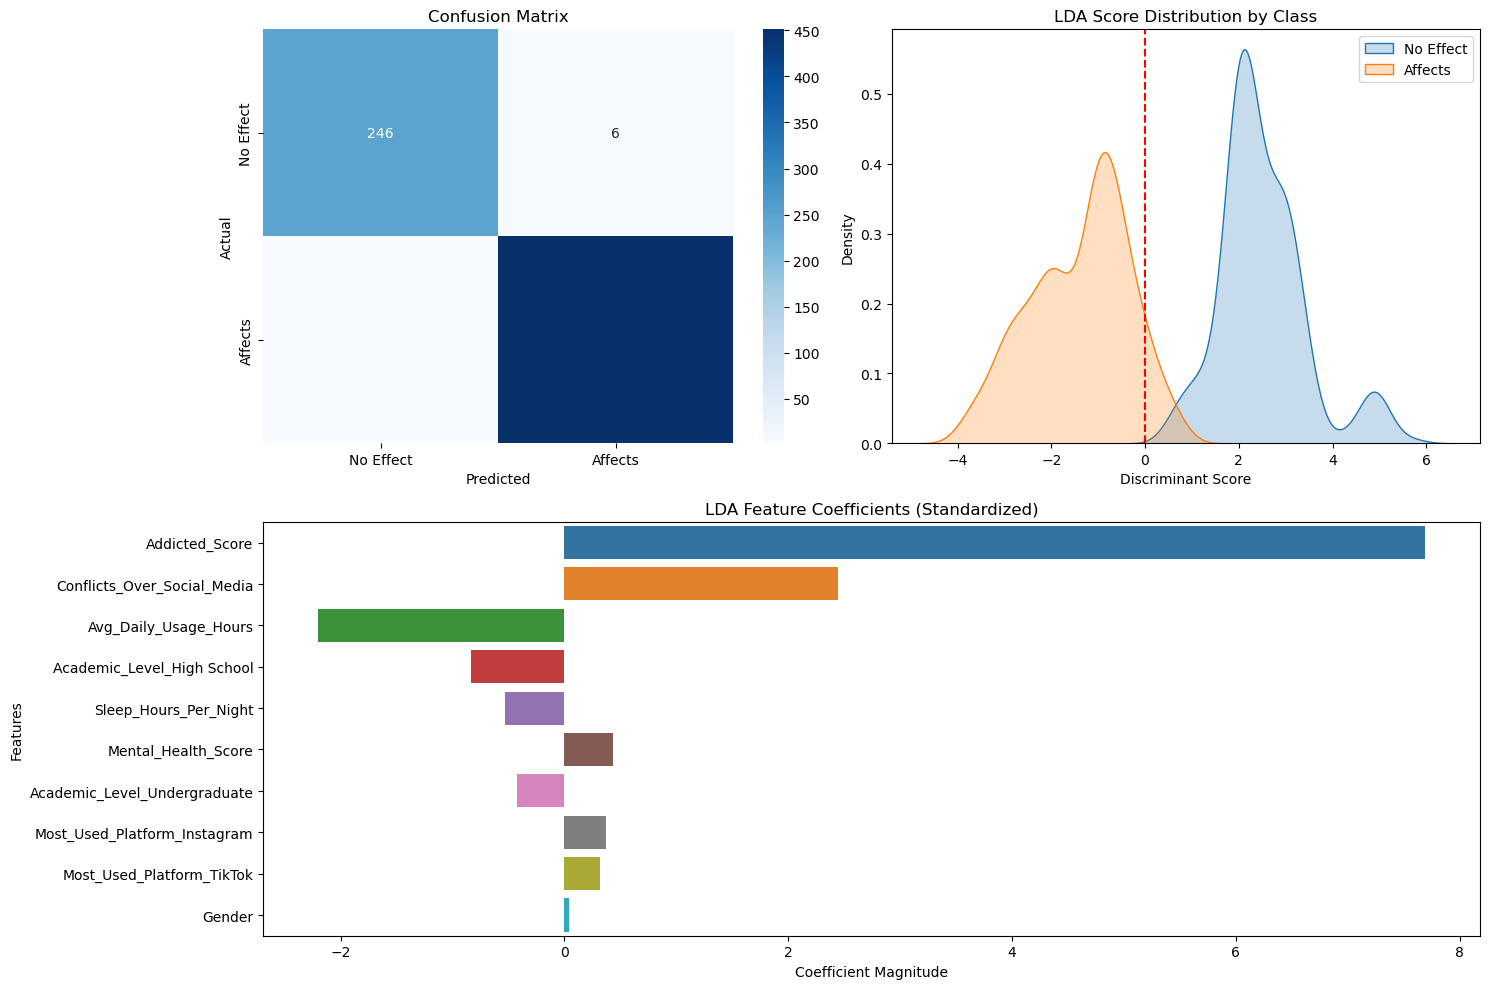


LDA Accuracy: 0.989

Top Discriminative Features:
                             Coefficient
Addicted_Score                  7.687130
Conflicts_Over_Social_Media     2.445317
Avg_Daily_Usage_Hours          -2.198558
Academic_Level_High School     -0.838612
Sleep_Hours_Per_Night          -0.529452


In [151]:
# 1. Data Preparation (assuming you've already cleaned/encoded)
predictors = ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 
              'Conflicts_Over_Social_Media', 'Addicted_Score', 'Gender', 
              'Academic_Level_Undergraduate', 'Academic_Level_High School', 
              'Most_Used_Platform_Instagram', 'Most_Used_Platform_TikTok']
X = data_combined[predictors]
y = data_encoded['Affects_Academic_Performance']

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. LDA Model
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_scaled, y)
y_pred = lda.predict(X_scaled)
y_scores = lda.transform(X_scaled).flatten()

# 3. Evaluation Metrics
print("Classification Report:")
print(classification_report(y, y_pred))

# 4. Visualizations
plt.figure(figsize=(15, 10))

# A. Confusion Matrix Heatmap
plt.subplot(2, 2, 1)
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Effect', 'Affects'],
            yticklabels=['No Effect', 'Affects'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# B. LDA Score Distribution by Class
plt.subplot(2, 2, 2)
sns.kdeplot(y_scores[y == 0], label='No Effect', shade=True)
sns.kdeplot(y_scores[y == 1], label='Affects', shade=True)
plt.axvline(x=0, color='r', linestyle='--')  # Decision boundary
plt.title('LDA Score Distribution by Class')
plt.xlabel('Discriminant Score')
plt.ylabel('Density')
plt.legend()

# C. Coefficient Magnitude Plot
plt.subplot(2, 1, 2)
coef_df = pd.DataFrame(lda.coef_.T, index=predictors, columns=['Coefficient'])
coef_df['abs'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)
sns.barplot(x='Coefficient', y=coef_df.index, data=coef_df)
plt.title('LDA Feature Coefficients (Standardized)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.tight_layout()

plt.savefig('lda_analysis.png', dpi=300)
plt.show()

# 5. Output Important Metrics
print(f"\nLDA Accuracy: {accuracy_score(y, y_pred):.3f}")
print("\nTop Discriminative Features:")
print(coef_df.sort_values('abs', ascending=False).drop('abs', axis=1).head(5))

In [153]:
# 1. Initial KMO Check
kmo_all, kmo_model = calculate_kmo(data_combined)
kmo_series = pd.Series(kmo_all, index=data_combined.columns)
print(f"\nInitial KMO Measure of Sampling Adequacy (Overall): {kmo_model:.3f}")

# 2. Remove variables with KMO < 0.5, focusing on region/platform dummies
# Identify region and platform dummy variables
region_cols = [col for col in data_combined.columns if col.startswith('Region_')]
platform_cols = [col for col in data_combined.columns if col.startswith('Most_Used_Platform_')]
low_kmo_vars = kmo_series[kmo_series < 0.5].index
low_kmo_region_platform = [col for col in low_kmo_vars if col in region_cols + platform_cols]

# Remove low KMO variables
data_filtered = data_combined.drop(columns=low_kmo_vars)

print(f"\nRemoved variables with KMO < 0.5")
print(f"Removed dummies(region/platform)")

# 3. Recalculate KMO on filtered data
kmo_all_filtered, kmo_model_filtered = calculate_kmo(data_filtered)
kmo_series_filtered = pd.Series(kmo_all_filtered, index=data_filtered.columns)
print(f"\nRecalculated KMO Measure of Sampling Adequacy (Overall): {kmo_model_filtered:.3f}")
print("Recalculated KMO per variable")

# 4. Proceed with Factor Analysis if KMO > 0.6
if kmo_model_filtered > 0.6:
    print("\nProceeding with Factor Analysis (KMO > 0.6)")

    # Bartlett’s Test of Sphericity on filtered data
    chi_square_value, p_value = calculate_bartlett_sphericity(data_filtered)
    print(f"\nBartlett’s Test of Sphericity (Filtered Data):")
    print(f"Chi-Square Value: {chi_square_value:.2f}")
    print(f"P-Value: {p_value:.3e}")

    # Perform Factor Analysis
    fa = FactorAnalyzer(n_factors=3, rotation='varimax', method='principal')  # 3 factors as an example
    fa.fit(data_filtered)

    # Factor Loadings
    loadings = pd.DataFrame(fa.loadings_, index=data_filtered.columns, columns=[f'Factor {i+1}' for i in range(3)])
    print("\nFactor Loadings (after Varimax rotation):")
    print(loadings)

    # Eigenvalues and Scree Plot
    ev, v = fa.get_eigenvalues()
    print("\nEigenvalues:")
    print(pd.DataFrame({'Eigenvalue': ev}))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(ev) + 1), ev, marker='o')
    plt.title('Scree Plot')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.grid(True)
    plt.savefig('scree_plot.png')
    plt.close()

    # Save results
    loadings.to_csv('factor_loadings.csv')
    pd.DataFrame({'Eigenvalue': ev}).to_csv('eigenvalues.csv')
else:
    print(f"\nOverall KMO ({kmo_model_filtered:.3f}) <= 0.6. Factor Analysis not recommended.")

C:\Users\Dell\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Initial KMO Measure of Sampling Adequacy (Overall): 0.378

Removed variables with KMO < 0.5
Removed dummies(region/platform)

Recalculated KMO Measure of Sampling Adequacy (Overall): 0.785
Recalculated KMO per variable

Proceeding with Factor Analysis (KMO > 0.6)

Bartlett’s Test of Sphericity (Filtered Data):
Chi-Square Value: 7694.38
P-Value: 0.000e+00

Factor Loadings (after Varimax rotation):
                                     Factor 1  Factor 2  Factor 3
Age                                 -0.064571 -0.100486  0.851702
Avg_Daily_Usage_Hours                0.889560 -0.043649 -0.105499
Sleep_Hours_Per_Night               -0.820406  0.118481  0.054865
Mental_Health_Score                 -0.938375 -0.024989  0.104469
Conflicts_Over_Social_Media          0.931783  0.054014 -0.161024
Addicted_Score                       0.971008  0.015007 -0.113514
Gender                               0.055116  0.015627  0.821281
Affects_Academic_Performance         0.868888  0.177388 -0.082928
Most_

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Factor loadings from your previous output
loadings_data = {
    'Factor 1': [-0.064571, 0.889560, -0.820406, -0.938375, 0.931783, 0.971008, 0.055116, 0.868888, -0.300691, -0.095892, -0.030171, 0.006097],
    'Factor 2': [-0.100486, -0.043649, 0.118481, -0.024989, 0.054014, 0.015007, 0.015627, 0.177388, -0.018607, -0.001648, -0.972151, 0.975096],
    'Factor 3': [0.851702, -0.105499, 0.054865, 0.104469, -0.161024, -0.113514, 0.821281, -0.082928, 0.330494, 0.310283, 0.048881, -0.035047]
}
variables = ['Age', 'Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 
             'Conflicts_Over_Social_Media', 'Addicted_Score', 'Gender', 'Affects_Academic_Performance', 
             'Most_Used_Platform_LinkedIn', 'Most_Used_Platform_VKontakte', 
             'Relationship_Status_In Relationship', 'Relationship_Status_Single']
loadings = pd.DataFrame(loadings_data, index=variables)

# 1. Heatmap of Factor Loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.2f', 
            cbar_kws={'label': 'Loading Value'})
plt.title('Heatmap of Factor Loadings')
plt.xlabel('Factors')
plt.ylabel('Variables')
plt.tight_layout()
plt.savefig('factor_loadings_heatmap.png')
plt.close()

# 2. Scatter Plot (Biplot Approximation) for Factor 1 vs Factor 2
plt.figure(figsize=(10, 8))
for i, var in enumerate(variables):
    x = loadings.loc[var, 'Factor 1']
    y = loadings.loc[var, 'Factor 2']
    plt.scatter(x, y, s=100, label=var)
    plt.arrow(0, 0, x, y, color='r', alpha=0.5, head_width=0.02)
    plt.text(x * 1.1, y * 1.1, var, fontsize=9)

plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title('Factor 1 vs Factor 2: Variable Loadings')
plt.xlabel('Factor 1 (Addiction and Mental Health Impact)')
plt.ylabel('Factor 2 (Relationship Status)')
plt.grid(True)
plt.tight_layout()
plt.savefig('factor_biplot_f1_f2.png')
plt.close()

In [157]:
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity, FactorAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume data_filtered is already created from previous filtering (KMO >= 0.5)
# If not, ensure it's defined as per the previous step

# 1. Perform Factor Analysis
fa = FactorAnalyzer(n_factors=3, rotation='varimax', method='principal')  # 3 factors based on previous eigenvalues
fa.fit(data_filtered)

# 2. Extract Factor Loadings
loadings = pd.DataFrame(fa.loadings_, index=data_filtered.columns, columns=[f'Factor {i+1}' for i in range(3)])

# 3. Assign Suitable Factor Names Based on Loadings
factor_names = {}
for factor_num in range(3):
    factor_col = f'Factor {factor_num + 1}'
    significant_loadings = loadings[abs(loadings[factor_col]) > 0.4].index.tolist()
    
    if any(var in significant_loadings for var in ['Avg_Daily_Usage_Hours', 'Conflicts_Over_Social_Media', 
                                                  'Addicted_Score', 'Mental_Health_Score', 
                                                  'Sleep_Hours_Per_Night', 'Affects_Academic_Performance']):
        factor_names[factor_col] = 'Social Media Addiction and Mental Health Impact'
    elif any(var in significant_loadings for var in ['Relationship_Status_In Relationship', 'Relationship_Status_Single']):
        factor_names[factor_col] = 'Relationship Status'
    elif any(var in significant_loadings for var in ['Age', 'Gender']):
        factor_names[factor_col] = 'Demographic Profile'
    else:
        factor_names[factor_col] = f'Factor {factor_num + 1} (Unspecified)'  # Fallback if no clear pattern

# 4. Rename Columns with Factor Names
loadings_named = loadings.rename(columns=factor_names)

# 5. Display and Save Results
print("\nFactor Loadings with Named Factors:")
print(loadings_named)
loadings_named.to_csv('factor_loadings_named.csv')

# 6. Eigenvalues and Scree Plot
ev, v = fa.get_eigenvalues()
print("\nEigenvalues:")
print(pd.DataFrame({'Eigenvalue': ev}))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.savefig('scree_plot.png')
plt.close()

# 7. Save Eigenvalues
pd.DataFrame({'Eigenvalue': ev}).to_csv('eigenvalues.csv')

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Factor Loadings with Named Factors:
                                     Social Media Addiction and Mental Health Impact  \
Age                                                                        -0.064571   
Avg_Daily_Usage_Hours                                                       0.889560   
Sleep_Hours_Per_Night                                                      -0.820406   
Mental_Health_Score                                                        -0.938375   
Conflicts_Over_Social_Media                                                 0.931783   
Addicted_Score                                                              0.971008   
Gender                                                                      0.055116   
Affects_Academic_Performance                                                0.868888   
Most_Used_Platform_LinkedIn                                                -0.300691   
Most_Used_Platform_VKontakte                                               -0.09589

In [ ]:
numeric_data = data[continuous_cols]
desc_stats = numeric_data.describe().T
desc_stats['skew'] = numeric_data.skew()
desc_stats['kurtosis'] = numeric_data.kurtosis()
desc_stats = desc_stats[['mean', 'std', '50%', 'skew', 'kurtosis']].rename(columns={'50%': 'median'})
print("\nDescriptive Statistics for Numeric Variables:")
print(desc_stats)
desc_stats.to_csv('descriptive_stats.csv')

# 4. Boxplots for Numeric Variables by Academic Impact
plt.figure(figsize=(12, 8))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Affects_Academic_Performance', y=col, data=data)
    plt.title(f'{col} by Academic Impact')
    plt.xlabel('Affects Academic Performance')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig('boxplots_academic_impact.png')
plt.show()

# 5. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

In [ ]:
numeric_data = data[continuous_cols]
desc_stats = numeric_data.describe().T
desc_stats['skew'] = numeric_data.skew()
desc_stats['kurtosis'] = numeric_data.kurtosis()
desc_stats = desc_stats[['count', 'mean', 'std', '50%', 'skew', 'kurtosis']].rename(columns={'50%': 'median'})
print("\nDescriptive Statistics for Numeric Variables:")
print(desc_stats)
desc_stats.to_csv('descriptive_stats.csv')

# 2. Boxplots for Numeric Variables by Academic Impact
plt.figure(figsize=(12, 8))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Affects_Academic_Performance', y=col, data=data)
    plt.title(f'{col} by Academic Impact')
    plt.xlabel('Affects Academic Performance')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig('boxplots_academic_impact.png')
plt.close()

# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.close()

In [ ]:
# Prepare data for LDA
# Predictors: Continuous variables + selected binary variables
predictors = ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 
              'Conflicts_Over_Social_Media', 'Addicted_Score', 'Gender', 
              'Academic_Level_Undergraduate', 'Academic_Level_High School', 
              'Most_Used_Platform_Instagram', 'Most_Used_Platform_TikTok']
X = data_combined[predictors]
y = data_encoded['Affects_Academic_Performance']

# Standardize predictors (already standardized continuous, re-standardize for consistency)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=predictors)

# 1. Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis(n_components=1)  # 1 component since binary classification
lda.fit(X_scaled_df, y)
y_pred = lda.predict(X_scaled_df)

# Evaluation
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual No', 'Actual Yes'], 
                              columns=['Predicted No', 'Predicted Yes'])
print(f"\nLDA Accuracy: {accuracy:.3f}")
print("\nConfusion Matrix:")
print(conf_matrix_df)
conf_matrix_df.to_csv('confusion_matrix.csv')

# Discriminant coefficients
coef_df = pd.DataFrame(lda.coef_, columns=predictors, index=['LD1'])
print("\nDiscriminant Coefficients (LD1):")
print(coef_df)
coef_df.to_csv('lda_coefficients.csv')

# Discriminant scores
lda_scores = lda.transform(X_scaled_df).flatten()  # 1D scores for binary classification

# Visualization: Discriminant Scores Plot
plt.figure(figsize=(10, 6))
sns.histplot(x=lda_scores, hue=y, stat='density', common_norm=False, palette='Set1', alpha=0.5)
plt.xlabel('Discriminant Scores (LD1)')
plt.ylabel('Density')
plt.title('Distribution of Discriminant Scores by Affects Academic Performance')
plt.grid(True)
plt.savefig('lda_scores_plot.png')
plt.close()


In [ ]:
data_combined.info()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# 1. Data Preparation (assuming you've already cleaned/encoded)
predictors = ['Avg_Daily_Usage_Hours', 'Sleep_Hours_Per_Night', 'Mental_Health_Score', 
              'Conflicts_Over_Social_Media', 'Addicted_Score', 'Gender', 
              'Academic_Level_Undergraduate', 'Academic_Level_High School', 
              'Most_Used_Platform_Instagram', 'Most_Used_Platform_TikTok']
X = data_combined[predictors]
y = data_encoded['Affects_Academic_Performance']

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. LDA Model
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_scaled, y)
y_pred = lda.predict(X_scaled)
y_scores = lda.transform(X_scaled).flatten()

# 3. Evaluation Metrics
print("Classification Report:")
print(classification_report(y, y_pred))

# 4. Visualizations
plt.figure(figsize=(15, 10))

# A. Confusion Matrix Heatmap
plt.subplot(2, 2, 1)
conf_mat = confusion_matrix(y, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Effect', 'Affects'],
            yticklabels=['No Effect', 'Affects'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# B. LDA Score Distribution by Class
plt.subplot(2, 2, 2)
sns.kdeplot(y_scores[y == 0], label='No Effect', shade=True)
sns.kdeplot(y_scores[y == 1], label='Affects', shade=True)
plt.axvline(x=0, color='r', linestyle='--')  # Decision boundary
plt.title('LDA Score Distribution by Class')
plt.xlabel('Discriminant Score')
plt.ylabel('Density')
plt.legend()

# C. Coefficient Magnitude Plot
plt.subplot(2, 1, 2)
coef_df = pd.DataFrame(lda.coef_.T, index=predictors, columns=['Coefficient'])
coef_df['abs'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)
sns.barplot(x='Coefficient', y=coef_df.index, data=coef_df)
plt.title('LDA Feature Coefficients (Standardized)')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.tight_layout()

plt.savefig('lda_analysis.png', dpi=300)
plt.show()

# 5. Output Important Metrics
print(f"\nLDA Accuracy: {accuracy_score(y, y_pred):.3f}")
print("\nTop Discriminative Features:")
print(coef_df.sort_values('abs', ascending=False).drop('abs', axis=1).head(5))

In [ ]:
data.describe()